
## Churn prediction - Kaggle competition
##### [Go to project Github repository](https://github.com/Olks/churn_prediction)
####  
This a an exploratory analysis and prediction with XGBoost for Kaggle competition:

["WSDM - KKBox's Churn Prediction Challenge
Can you predict when subscribers will churn?"](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/)

The competition is over but you can still download the data, read notebooks of participants and learn!
<br>And then submit your prediction to see how well your model perform. 


#### Overview of the task
The goal of the competition is to predict if the user of the music streaming service will renew the subscription. Usually the subscription lasts 30 days and can be automatically renewed.
<br>Churn definition (in data description on Kaggle)
>The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.


## Loading the data

The files set provided contains bigger files with data till the end of February 2017 and additional files ("v2" suffix) with update of March 2017.
<br>They are too big to load them all into python but we can concatenate some of them in GNU terminal (e.g. on Windows in Git Bash):
><code>cat transactions.csv > transactions_v3.csv; tail -n +2 transactions_v2.csv >> transactions_v3.csv </code>

Import libraries, helper functions and data files; details:  [Go to project Github repository](https://github.com/Olks/churn_prediction)

In [1]:
# Import libraries and helper functions
%run -i "helpers.py"

In [2]:
# Load data files
%run -i "files_loader.py"

In [3]:
# Let's check what we have defined after running helpers.py
%whos

Variable                              Type         Data/Info
------------------------------------------------------------
PROJECT_DIR                           str          C:\Users\Olks\Desktop\churn_prediction
calculate_last_subsciption_features   function     <function calculate_last_<...>es at 0x0000028C760E7510>
calculate_transactional_features      function     <function calculate_trans<...>es at 0x0000028C791B6B70>
get_labels                            function     <function get_labels at 0x0000028C7400B9D8>
join                                  function     <function join at 0x0000028C716787B8>
members_v3_path                       str          C:\Users\Olks\Desktop\chu<...>prediction\members_v3.csv
pd                                    module       <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt                                   module       <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
random                                module       <module 'random' f

#### Labels

In [6]:
# labels_january = get_labels(transactions_v3, "20170201")
# labels_february = get_labels(transactions_v3, "20170301")

labels_january = pd.read_pickle("labels_january.pkl")
labels_february = pd.read_pickle("labels_february.pkl")

In [5]:
labels_january.to_pickle("labels_january.pkl")
labels_february.to_pickle("labels_february.pkl")

In [49]:
scala_labels_january = pd.read_csv("scala_labels_january.csv")
scala_labels_february = pd.read_csv("scala_labels_february.csv")

In [40]:
# scala_labels_january = pd.read_csv("scala_labels_january_one_month.csv")
# scala_labels_february = pd.read_csv("scala_labels_february_one_month.csv")

### Exploration of the data

#### First data check: reading 1000 lines per file because they are too big read them all at once
- Later we can read selected columns or whole files by chunks

In [4]:
train = pd.read_csv(train_path, nrows=1000)
train_v2 = pd.read_csv(train_v2_path, nrows=1000)
user_logs = pd.read_csv(user_logs_path, nrows=1000) 
user_logs_v2 = pd.read_csv(user_logs_v2_path, nrows=1000)
sample_submission_zero = pd.read_csv(sample_submission_zero_path, nrows=1000)
sample_submission_v2 = pd.read_csv(sample_submission_v2_path, nrows=1000)
transactions = pd.read_csv(transactions_path, nrows=1000)
transactions_v2 = pd.read_csv(transactions_v2_path, nrows=1000)
transactions_v3 = pd.read_csv(transactions_v3_path, nrows=1000) 
members_v3 = pd.read_csv(members_v3_path, nrows=1000)

In [5]:
tables = {
    "train": train, 
    "train_v2": train_v2, 
    "user_logs": user_logs,
    "user_logs_v2": user_logs_v2, 
    "sample_submission_zero": sample_submission_zero, 
    "sample_submission_v2": sample_submission_v2,
    "transactions": transactions,
    "transactions_v2": transactions_v2,
    "transactions_v3": transactions_v3,
    "members_v3": members_v3
}

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
for table_name, table in tables.items():
    print("\n------------------------------------------------------")
    print(f"Table name: \"{table_name}\"")
    display(table.describe().transpose())
    display(table.dtypes.transpose())

### Basic Trasactional Features

The challenge winner, Bryian Gregory, gives a few tips in his article, <br>
**"Predicting Customer Churn: Extreme Gradient Boosting with Temporal Data"**
<br>
https://medium.com/@bryan.gregory1/predicting-customer-churn-extreme-gradient-boosting-with-temporal-data-332c0d9f32bf

He gives a hint that the features should be relative to a cutoff day. He calls it "Relative Refactoring Method".
<br> So we should transform the day of first transaction into the number of days from the first transaction.
<br> Only if days are "special" like holidays we could live them as exact days. We should not mix those approaches.
<br> Here, only relative features will be calaculated.

1. **days_from_start** = Number of days from first transaction
2. **transactions_num** = Number or transactions
3. **cancelations_num** = Number of cancelations
4. **last_is_auto_renew** = If last subscription is renewed automatically
5. **subscription_length** = Length of last subscription

Now we need to load whole files or columns.
To create our first 3 features we need 4 columns from "transactions" files:
<br>
"msno", "transaction_date", "membership_expire_date", "is_cancel".
<br> UPDATE: Tocalculate 5 features we need 5 columns (same as previously plus "is_auto_renew")

In [7]:
# filter only users that have lable and create features for them
transactions_jan = labels_january.merge(transactions_v3)
train_transactional_features_jan = calculate_transactional_features(transactions_jan, '20170201')
train_last_subsciption_features_jan = calculate_last_subsciption_features(transactions_jan, '20170201')
train_with_features_jan = train_transactional_features_jan.merge(
                                            train_last_subsciption_features_jan, on="msno")

In [8]:
transactions_feb = labels_february.merge(transactions_v3)
train_transactional_features_feb = calculate_transactional_features(transactions_feb, '20170301')
train_last_subsciption_features_feb = calculate_last_subsciption_features(transactions_feb, '20170301')
train_with_features_feb = train_transactional_features_feb.merge(
                                            train_last_subsciption_features_feb, on="msno")

In [9]:
transactions_mar = sample_submission_v2.merge(transactions_v3)
test_transactional_features_mar = calculate_transactional_features(transactions_mar, '20170401')
test_last_subsciption_features_mar = calculate_last_subsciption_features(transactions_mar, '20170401')
test_with_features_mar = test_transactional_features_mar.merge(
                                            test_last_subsciption_features_mar, on="msno")

In [10]:
train_with_features_jan = train_with_features_jan.merge(labels_january)
train_with_features_feb = train_with_features_feb.merge(labels_february)

In [ ]:
# train_with_features_jan = train_with_features_jan.merge(scala_labels_january)
# train_with_features_feb = train_with_features_feb.merge(scala_labels_february)

### Logs features

Logs file is too big to load it into the computer memory.
Let's use pyspark to filter out monthly logs!

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local", "First App")
my_spark = SparkSession.builder.getOrCreate()
file_path = user_logs_path
user_logs = my_spark.read.csv(file_path, header=True)
user_logs.show()
user_logs.createOrReplaceTempView("user_logs")
print(my_spark.catalog.listTables())

# filter only logs from january and february and save them to csv
query_january = "SELECT* FROM user_logs WHERE date >= 20170101 AND date <= 20170131"
january_logs = my_spark.sql(query_january)
january_logs.coalesce(1).write.format('csv').save("january_logs", header='true')

query_february = "SELECT* FROM user_logs WHERE date >= 20170201 AND date <= 20170228"
february_logs = my_spark.sql(query_february)
february_logs.coalesce(1).write.format('csv').save("february_logs", header='true')

my_spark.stop()

In [13]:
january_logs_path = join(PROJECT_DIR, "january_logs.csv")
january_logs = pd.read_csv(january_logs_path)
january_last_user_log = calculate_logs_features(january_logs, "20170201")
del january_logs

In [14]:
february_logs_path = join(PROJECT_DIR, "february_logs.csv")
february_logs = pd.read_csv(february_logs_path)
february_last_user_log = calculate_logs_features(february_logs, "20170301")
del february_logs

In [16]:
march_logs_path = join(PROJECT_DIR, "user_logs_v2.csv")
march_logs = pd.read_csv(march_logs_path)
march_logs = march_logs.loc[march_logs.date >= 20170301]
march_last_user_log = calculate_logs_features(march_logs, "20170401")
del march_logs

In [59]:
all_my_train_features_jan = train_with_features_jan.merge(january_last_user_log, 
                                                          how="left", on="msno")

# assing a value 99 for users who did not logged in the last month
# max_value = all_my_train_features_jan["days_from_last_log"].max()
all_my_train_features_jan["days_from_last_log"] = \
        all_my_train_features_jan["days_from_last_log"].fillna(99)   #max_value+1
all_my_train_features_jan = all_my_train_features_jan.fillna(0)

In [125]:
all_my_train_features_feb = train_with_features_feb.merge(february_last_user_log, 
                                                          how="left", on="msno")

# assing a value 99 for users who did not logged in the last month
# max_value = all_my_train_features_feb["days_from_last_log"].max()
all_my_train_features_feb["days_from_last_log"] = \
        all_my_train_features_feb["days_from_last_log"].fillna(99)   #max_value+1
all_my_train_features_feb = all_my_train_features_feb.fillna(0)

In [61]:
all_my_test_features = test_with_features_mar.merge(march_last_user_log, how="left", on="msno")

# assing a value 99 for users who did not logged in the last month
# max_value = all_my_test_features["days_from_last_log"].max()
all_my_test_features["days_from_last_log"] = \
        all_my_test_features["days_from_last_log"].fillna(99)   #max_value+1
all_my_test_features = all_my_test_features.fillna(0)

### Features exploration

In [45]:
train_with_features_deduplicated.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transaction_date_count,2363626.0,9.116394,8.887318,1.0,1.0,5.0,16.0,71.0
is_cancel_sum,2363626.0,0.362515,0.569036,0.0,0.0,0.0,1.0,20.0
subscription_length_sum,2363626.0,322.885609,711.648321,-48770.0,30.0,218.0,518.0,14855.0
days_from_start,2363626.0,491.734499,243.820651,1.0,275.0,525.0,736.0,790.0


In [46]:
test_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
transaction_date_count,2426143.0,9.471311,9.294885,1.0,2.0,5.0,16.0,244.0
is_cancel_sum,2426143.0,0.367655,0.577234,0.0,0.0,0.0,1.0,21.0
subscription_length_sum,2426143.0,384.497706,1185.711344,-48740.0,31.0,244.0,591.0,232521.0
days_from_start,2426143.0,511.735603,250.845944,1.0,280.0,542.0,759.0,821.0


### Does churn depend on number of days from the first transaction?
- Churning user have a bit lower number of days that passed from the first transaction.

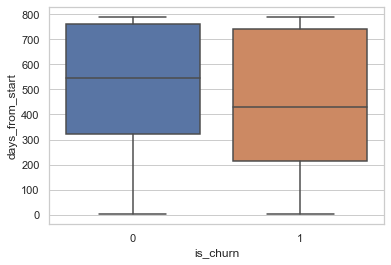

In [20]:
ax = sns.boxplot(x="is_churn", y="days_from_start", data=train_with_features_deduplicated)

### Does churn depend on length of the current subscription?
- This variable needs deeper inversigation.

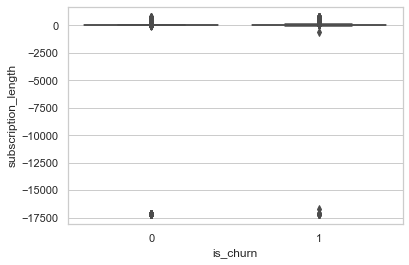

In [26]:
ax = sns.boxplot(x="is_churn", y="subscription_length", 
                 data=train_with_features_deduplicated) #.loc[train_with_features_deduplicated.subscription_length >= 0])

### Does churn depend on number of all transactions that user made?
- Yes, users who churn made a bit less transactions (this is correlated with the first variable)

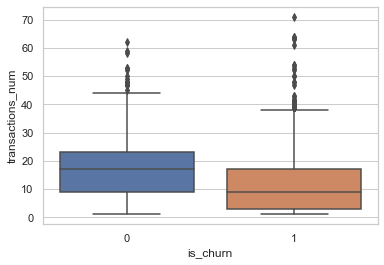

In [28]:
ax = sns.boxplot(x="is_churn", y="transactions_num", data=train_with_features_deduplicated)

### Does churn depend on number of all cancelations that user made?
- Yes, users who churn made more cancelations.

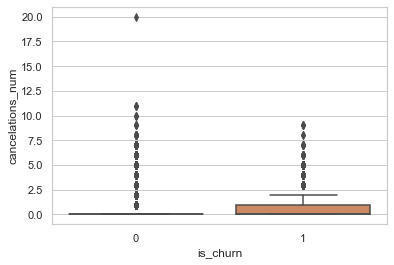

In [29]:
ax = sns.boxplot(x="is_churn", y="cancelations_num", data=train_with_features_deduplicated)

### Does churn depend on the fact if the current subscription is automaticaly renewed?
- Yes, users whose subscripton is automatically renewed churn much less often.

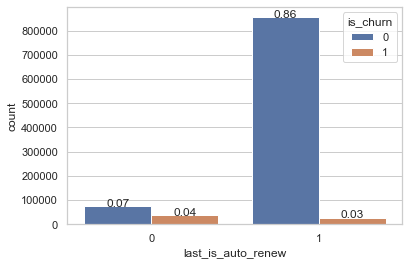

In [44]:
ax = sns.countplot(x="last_is_auto_renew", hue="is_churn", data=train_with_features_deduplicated)
total=train_with_features_deduplicated.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 

In [48]:
print(f"{0.03/0.89: 0.2%} of users whose subscription is automatically renewed churn")
print(f"{0.04/0.11: 0.2%} of users whose subscription is NOT automatically renewed churn")

 3.37% of users whose subscription is automatically renewed churn
 36.36% of users whose subscription is NOT automatically renewed churn


### Members data
Not all users are members and using the data will create a lot of missing valus
<br>But we can at least add boolean feature if the user is a member

In [112]:
members = pd.read_csv(members_v3_path)
members["is_member"] = 1

In [ ]:
members_feb = members.loc[members.registration_init_time <= 20170228]
all_my_train_features_feb = all_my_train_features_feb.merge(members_feb[["msno", "is_member"]], 
                                                            on="msno", how="left")
all_my_train_features_feb["is_member"] = all_my_train_features_feb["is_member"].fillna(0)

In [ ]:
members_jan = members.loc[members.registration_init_time <= 20170131]
all_my_train_features_jan = all_my_train_features_jan.merge(members_jan[["msno", "is_member"]], 
                                                            on="msno", how="left")
all_my_train_features_jan["is_member"] = all_my_train_features_jan["is_member"].fillna(0)

In [ ]:
members_mar = members.loc[members.registration_init_time <= 20170331]
all_my_test_features = all_my_test_features.merge(members_mar[["msno", "is_member"]], 
                                                            on="msno", how="left")
all_my_test_features["is_member"] = all_my_test_features["is_member"].fillna(0)

### Modeling with XGboost
Based on tutorial: <br>
["Using XGBoost in Python"](https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_campaignid=9942305733&utm_adgroupid=100189364546&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034352&utm_targetid=aud-299261629574:dsa-929501846124&utm_loc_interest_ms=&utm_loc_physical_ms=9060640&gclid=Cj0KCQjw0YD4BRD2ARIsAHwmKVkoOKq4tg0ihd-a5jx70ZIDySVNt1e8bTrBYOOQkPIaLb5aElQY3FgaApotEALw_wcB)

In [196]:
# Without logs features (only transactional)
train_set = train_with_features_jan
validation_set = train_with_features_feb
test_set = test_with_features_mar
validation_set["p_25"] = 0

In [63]:
# With logs features
train_set = all_my_train_features_jan
validation_set = all_my_train_features_feb
test_set = all_my_test_features
validation_set["p_25"] = 0

train_set = train_set.drop(columns="is_churn").merge(scala_labels_january)
validation_set = validation_set.drop(columns="is_churn").merge(scala_labels_february)

In [130]:
# Using available lables from "train.csv"
# Trainign on february
# Validating on January (to use train.csv in model)
train = pd.read_csv("train.csv")
train_set = all_my_train_features_feb
validation_set = all_my_train_features_jan
test_set = all_my_test_features
train_set["p_25"] = 0

train_set = train_set.drop(columns="is_churn").merge(train)
validation_set = validation_set.drop(columns="is_churn").merge(scala_labels_february)

In [152]:
train_set["price_diff"] = train_set["last_plan_list_price"] - train_set["last_actual_amount_paid"]
validation_set["price_diff"]  = validation_set["last_plan_list_price"] - validation_set["last_actual_amount_paid"]
test_set["price_diff"]  = test_set["last_plan_list_price"] - test_set["last_actual_amount_paid"]

In [185]:
# from sklearn.model_selection import train_test_split
# random.seed(1)
# train_set, test_set = train_test_split(all_my_train_features, test_size=0.2)

In [155]:
#XGBoost Model

random.seed(1)
features = [
#     "is_member",
    "transactions_num", 
    "is_cancel", 
    "days_from_start", 
    "last_is_auto_renew", 
    "last_payment_plan_days",
    "price_diff",
    "last_plan_list_price",
    "last_actual_amount_paid",
    "last_transactions_num", # +
    "p_3",
    "p_6",
    "p_8",
    "p_10",
    "p_11",
    "p_12",
    "p_13",
    "p_14",
    "p_15",
    "p_16",
    "p_17",
    "p_18",
    "p_19",
    "p_20",
    "p_21",
    "p_22",
    "p_23",
    "p_25",
    "p_26",
    "p_27",
    "p_28",  
    "p_29",
    "p_30",
    "p_31",
    "p_32",
    "p_33",
    "p_34",
    "p_35",
    "p_36",
    "p_37",
    "p_38",
    "p_39",
    "p_40",
    "p_41",
#     "days_from_last_log", # -
    "last_month_logs_num", # +
#     "total_secs_sum", # -
#     "total_secs_mean",
#     "num_unq_sum",
#     "num_unq_mean",
    "num_100_sum", # +
    "num_25_sum", # +
#     "num_100_mean" # -
    
# worse result with all of them!
#     "num_25_mean",
#     "num_50_sum",
#     "num_50_mean",
#     "num_75_sum",
#     "num_75_mean",
#     "num_985_sum",
#     "num_985_mean",
#     "num_100_mean"
    ]
X_train, y_train = train_set[features], train_set["is_churn"]
X_validation, y_validation = validation_set[features], validation_set["is_churn"]

xgb_model = xgb.XGBClassifier(verbosity=1,
                              max_depth=4, 
                              learning_rate=0.1,
                              objective= "binary:logistic",
                              n_jobs=-1).fit(X_train, y_train)

print("Accuracy of XGB classifier on training set: {:.2f}"
       .format(xgb_model.score(X_train, y_train)))
print("Accuracy of XGB classifier on validation set: {:.2f}"
       .format(xgb_model.score(X_validation[X_train.columns], y_validation)))

Accuracy of XGB classifier on training set: 0.96
Accuracy of XGB classifier on validation set: 0.98


### Log loss for train and test set

In [156]:
from sklearn.metrics import log_loss
# log_loss(y_true, y_pred)

prediction_validation = xgb_model.predict_proba(X_validation[features])
prediction_train = xgb_model.predict_proba(X_train[features])
y_pred_validation = pd.DataFrame(prediction_validation).loc[:,1]
y_pred_train = pd.DataFrame(prediction_train).loc[:,1]
y_true_validation = y_validation
y_true_train = y_train

print("The lower log loss the better")
print(f"Validation set log loss: {log_loss(y_true_validation, y_pred_validation, normalize=True)}")
print(f"Train set log loss: {log_loss(y_true_train, y_pred_train, normalize=True)}")

The lower log loss the better
Validation set log loss: 0.10658114589873867
Train set log loss: 0.10209953870478108


In [ ]:
transactiona_features = [   
    "transactions_num", 
    "is_cancel", 
    "days_from_start", 
    "last_is_auto_renew", 
    "last_payment_plan_days",
    "last_plan_list_price",
    "last_actual_amount_paid",
    "last_transactions_num"
]

The lower log loss the better

# All transactional features
Validation set log loss: 0.08987856495235082
Train set log loss: 0.06600082780591267

# All transactional features (but only payement: p_ 28,31,32,33,34,35,38,39,41)
Validation set log loss: 0.09049935917952993
Train set log loss: 0.06564811247769056
    
# All transactional features (but only payement: p_ 28,31,32,33,34,35,38,39,41)
# without "last_transactions_num"
Validation set log loss: 0.09174819306929823
Train set log loss: 0.06621224000395727

# All transactional features (but without payements)
Validation set log loss: 0.09308671642720492
Train set log loss: 0.06726382501786995
# Kaggle - Public Score: 0.14073
    
# All transactional features and some logs features
Validation set log loss: 0.06717202937332989
Train set log loss: 0.049447254019830376
# Kaggle - Public Score: 0.15425 
    
# ------- Scala script labels ------ #
# All transactional features and some logs features
Validation set log loss: 0.05747874824669723
Train set log loss: 0.04295457049418308
# Kaggle - Public Score: 0.14808

# All transactional features and some logs features 
# scala lables based with last month history cutoff
# As suggested in original scala file
Validation set log loss: 0.05255267561716552
Train set log loss: 0.03794085620411787
# Kaggle - Public Score: 0.15269


# All transactional features
# Without logs
# Scala labels - not one month - one year history cutoff
Validation set log loss: 0.08625422304018238
Train set log loss: 0.07125698383262877
# Kaggle - Public Score: 0.13366

# All transactional features
# With "days_from_last_log" - new definition: 99 if more than max
# Scala labels - not one month - one year history cutoff
Validation set log loss: 0.057690872125019096
Train set log loss: 0.04355883115983883
# Kaggle - Public Score: 0.14931

# All transactional features
# With last_month_logs_num
# Scala labels - not one month - one year history cutoff
The lower log loss the better
Validation set log loss: 0.06929316659167535
Train set log loss: 0.05568723277924711
# Kaggle - Public Score: 0.13187

# All transactional features
# With last_month_logs_num + num_unq_sum
# Scala labels - not one month - one year history cutoff
Validation set log loss: 0.06946175270529986
Train set log loss: 0.05572308866457669
# Kaggle - Public Score: 0.13232




# -----: train.csv ------ #
# All transactional features
# With last_month_logs_num
Training: february
Validating: January
Validation set log loss: 0.10747140400553815
Train set log loss: 0.10226178727181985
# Kaggle - Public Score: 0.12412  # 87th /574 

# train.csv
# All transactional features
# With: last_month_logs_num + num_100_sum
Training: february
Validating: January
Validation set log loss: 0.1073091199877406
Train set log loss: 0.10222664729931981
# Kaggle - Public Score: 0.12375 # 78th /574 


#### -------  !! WINNER !! ------ #######
# train.csv
# All transactional features
# With: last_month_logs_num + num_100_sum + num_25_sum
Training: february
Validating: January
Validation set log loss: 0.1067291828208083
Train set log loss: 0.101972377573934
# Kaggle - Public Score: 0.12343 # 75th


# train.csv
# All transactional features
# With: last_month_logs_num + num_100_sum + num_25_sum + is_member
Training: february
Validating: January
Validation set log loss: 0.10722052232246496
Train set log loss: 0.1021666782706119
# Kaggle - Public Score: 0.12357


# train.csv
# All transactional features
# With: last_month_logs_num + num_100_sum + num_25_sum + total_secs_sum 
Training: february
Validating: January
Validation set log loss: 0.10718066865746934
Train set log loss: 0.1021210024684198
# Kaggle - Public Score: - (total_secs_sum  not improving


# train.csv
# All transactional features
# With: last_month_logs_num + num_100_sum + num_25_sum + num_100_mean 
Training: february
Validating: January
Validation set log loss: 0.10643713119846124
Train set log loss: 0.1022159036170292
# Kaggle - Public Score: - (num_100_mean  not improving)


# train.csv
# All transactional features
# With: last_month_logs_num + num_100_sum + num_25_sum  
# without: last_transactions_num
Training: february
Validating: January
Validation set log loss: 0.10661088164779728
Train set log loss: 0.10291233635956142
# Kaggle - Public Score: 0.12380


# train.csv
# All transactional features
# With: last_month_logs_num + num_100_sum + num_25_sum  
# "price_diff" instead of list price and actual price
Training: february
Validating: January
Validation set log loss: 0.1090252290640523
Train set log loss: 0.10466540764110334
# Kaggle - Public Score: - (not improving!)

# train.csv
# All transactional features
# With: last_month_logs_num + num_100_sum + num_25_sum  
# "price_diff" additionally
Training: february
Validating: January
Validation set log loss: 0.10658114589873867
Train set log loss: 0.10209953870478108
# Kaggle - Public Score: 0.12382

##### !! Changing just lables in training set (using those from train.csv) increase the score on the Leader Board a lot !!
Looks like they are correct one.
<br>But we cannot produce more for different time periods with scala script (or some other way.
<br>So we have to use only users with subscription expiring in February. 

### Features importance
- We need to remember that there are many types of feature importance: 'weight', 'gain', 'cover',
- Default: ‘weight’: the number of times a feature is used to split the data across all trees. It may be lower for features with lower cardinality (like True/False features, so our "last_is_auto_renew"),
- ‘gain’: the average gain across all splits the feature is used in.

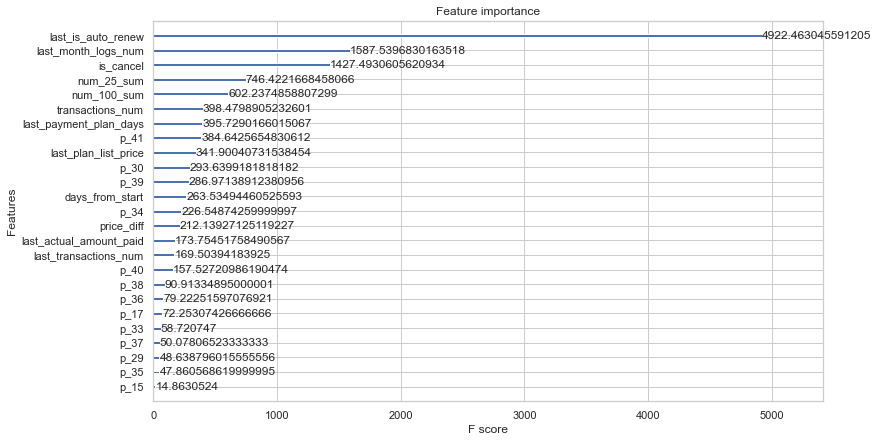

In [157]:
xgb.plot_importance(xgb_model, importance_type="gain")
plt.rcParams['figure.figsize'] = [12, 7]
plt.show()

In [158]:
submission = xgb_model.predict_proba(test_set[features])

In [159]:
submission_int = xgb_model.predict(test_set[features])

In [160]:
final_submission = pd.DataFrame({"msno": test_set.msno.reset_index(drop=True), 
                                 "is_churn": pd.DataFrame(submission).loc[:,1]})

In [161]:
final_submission.to_csv("submission_31.csv", index=False)

###### Train set log loss < Test set log loss  => Overfitting

#### Ideas to improve:
  - for overfitting: decrease max_depth or change other parameters,
  - create more features,
  - add different periods - maybe there is seasonality?